In [1]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from PIL import ImageFile
import tensorflow as tf
import tensorflow.keras.backend as K

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        pt = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)
        loss = -alpha * K.pow(1. - pt, gamma) * K.log(pt)
        return K.mean(loss)
    return focal_loss_fixed

In [3]:
base_dir = "C:/Users/josep/OneDrive/Documenten/project419/FracAtlas/images"
fractured_dir = os.path.join(base_dir, "1_Fractured")
nonfractured_dir = os.path.join(base_dir, "0_Non_fractured")

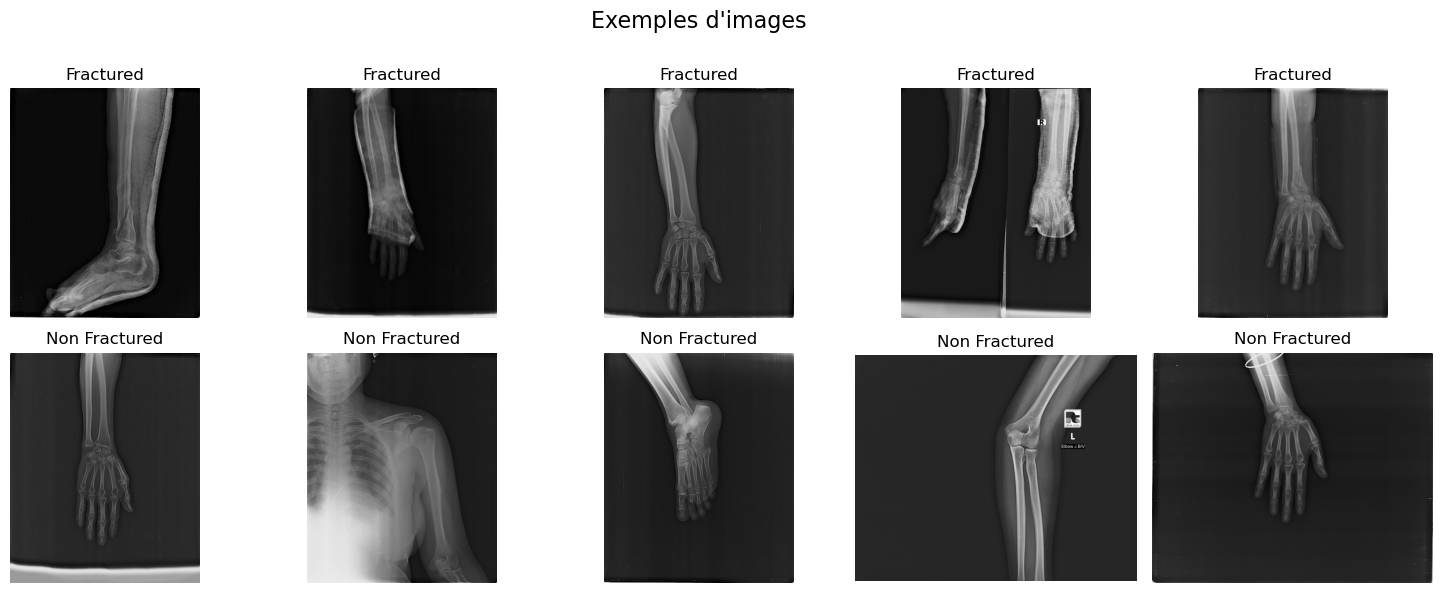

In [4]:
def display_samples():
    num_images = 5
    fractured_imgs = random.sample([f for f in os.listdir(fractured_dir) if f.endswith('.jpg')], num_images)
    nonfractured_imgs = random.sample([f for f in os.listdir(nonfractured_dir) if f.endswith('.jpg')], num_images)
    
    fig, axs = plt.subplots(2, num_images, figsize=(15, 6))
    fig.suptitle("Exemples d'images", fontsize=16)
    
    for i in range(num_images):
        axs[0, i].imshow(mpimg.imread(os.path.join(fractured_dir, fractured_imgs[i])), cmap='gray')
        axs[0, i].axis('off')
        axs[0, i].set_title("Fractured")
        
        axs[1, i].imshow(mpimg.imread(os.path.join(nonfractured_dir, nonfractured_imgs[i])), cmap='gray')
        axs[1, i].axis('off')
        axs[1, i].set_title("Non Fractured")
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

# Exécuter l'affichage des échantillons
display_samples()

In [5]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.3
)


In [6]:
train_generator = datagen.flow_from_directory(
    directory=base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    directory=base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=True
)

Found 1759 images belonging to 2 classes.
Found 752 images belonging to 2 classes.


In [7]:
y_train = train_generator.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

In [ ]:
# on Charge le modèle de base
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Configuration du fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-15]:
    layer.trainable = False

# Ajout des couches personnalisées
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

#  modèle final
model = Model(inputs=base_model.input, outputs=predictions)

In [10]:
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=focal_loss(gamma=2.0, alpha=0.25),
    metrics=['accuracy']
)

In [11]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

lr_reduction = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath="best_model.h5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

In [12]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    class_weight=class_weights,
    callbacks=[early_stop, lr_reduction, checkpoint]
)


c:\Users\josep\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6826 - loss: 0.0610
Epoch 1: val_loss improved from inf to 0.05304, saving model to best_model.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 765s 12s/step - accuracy: 0.6828 - loss: 0.0609 - val_accuracy: 0.8298 - val_loss: 0.0530 - learning_rate: 1.0000e-05
Epoch 2/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7354 - loss: 0.0554
Epoch 2: val_loss did not improve from 0.05304
55/55 ━━━━━━━━━━━━━━━━━━━━ 508s 9s/step - accuracy: 0.7355 - loss: 0.0554 - val_accuracy: 0.8245 - val_loss: 0.0536 - learning_rate: 1.0000e-05
Epoch 3/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7443 - loss: 0.0450
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 3: val_loss did not improve from 0.05304
55/55 ━━━━━━━━━━━━━━━━━━━━ 516s 8s/step - accuracy: 0.7441 - loss: 0.0450 - val_accuracy: 0.8271 - val_loss: 0.0545 - learning_rate: 1.0000e-05
Epoch 4/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7494 - loss: 0.0436
Epoch 4: val_loss did not improve from 0.05304
55/55 ━━━━━━━━━━━━━━━━━━━━ 329s 6s/step - accuracy: 0.7494 - loss: 0.0436 - val_accuracy: 0.8245 - v

55/55 ━━━━━━━━━━━━━━━━━━━━ 317s 6s/step - accuracy: 0.7543 - loss: 0.0456 - val_accuracy: 0.8285 - val_loss: 0.0488 - learning_rate: 5.0000e-06
Epoch 6/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7395 - loss: 0.0469
Epoch 6: val_loss did not improve from 0.04878
55/55 ━━━━━━━━━━━━━━━━━━━━ 272s 5s/step - accuracy: 0.7398 - loss: 0.0469 - val_accuracy: 0.8231 - val_loss: 0.0499 - learning_rate: 5.0000e-06
Epoch 7/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7726 - loss: 0.0411
Epoch 7: val_loss improved from 0.04878 to 0.04576, saving model to best_model.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 271s 5s/step - accuracy: 0.7724 - loss: 0.0411 - val_accuracy: 0.8324 - val_loss: 0.0458 - learning_rate: 5.0000e-06
Epoch 8/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7756 - loss: 0.0400
Epoch 8: val_loss improved from 0.04576 to 0.04468, saving model to best_model.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 274s 5s/step - accuracy: 0.7757 - loss: 0.0400 - val_accuracy: 0.8271 - val_loss: 0.0447 - learning_rate: 5.0000e-06
Epoch 9/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7737 - loss: 0.0373
Epoch 9: val_loss improved from 0.04468 to 0.04288, saving model to best_model.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 315s 5s/step - accuracy: 0.7738 - loss: 0.0373 - val_accuracy: 0.8258 - val_loss: 0.0429 - learning_rate: 5.0000e-06
Epoch 10/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7677 - loss: 0.0406
Epoch 10: val_loss did not improve from 0.04288
55/55 ━━━━━━━━━━━━━━━━━━━━ 272s 4s/step - accuracy: 0.7680 - loss: 0.0406 - val_accuracy: 0.8311 - val_loss: 0.0446 - learning_rate: 5.0000e-06
Epoch 11/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7512 - loss: 0.0367
Epoch 11: val_loss improved from 0.04288 to 0.04166, saving model to best_model.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 217s 4s/step - accuracy: 0.7514 - loss: 0.0367 - val_accuracy: 0.8324 - val_loss: 0.0417 - learning_rate: 5.0000e-06
Epoch 12/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7934 - loss: 0.0342
Epoch 12: val_loss improved from 0.04166 to 0.04016, saving model to best_model.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 299s 5s/step - accuracy: 0.7933 - loss: 0.0342 - val_accuracy: 0.8311 - val_loss: 0.0402 - learning_rate: 5.0000e-06
Epoch 13/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7846 - loss: 0.0361
Epoch 13: val_loss improved from 0.04016 to 0.03942, saving model to best_model.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 243s 4s/step - accuracy: 0.7847 - loss: 0.0360 - val_accuracy: 0.8298 - val_loss: 0.0394 - learning_rate: 5.0000e-06
Epoch 14/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7870 - loss: 0.0365
Epoch 14: val_loss improved from 0.03942 to 0.03603, saving model to best_model.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 255s 5s/step - accuracy: 0.7870 - loss: 0.0365 - val_accuracy: 0.8271 - val_loss: 0.0360 - learning_rate: 5.0000e-06
Epoch 15/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.7840 - loss: 0.0348
Epoch 15: val_loss improved from 0.03603 to 0.03551, saving model to best_model.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 1225s 23s/step - accuracy: 0.7840 - loss: 0.0348 - val_accuracy: 0.8351 - val_loss: 0.0355 - learning_rate: 5.0000e-06


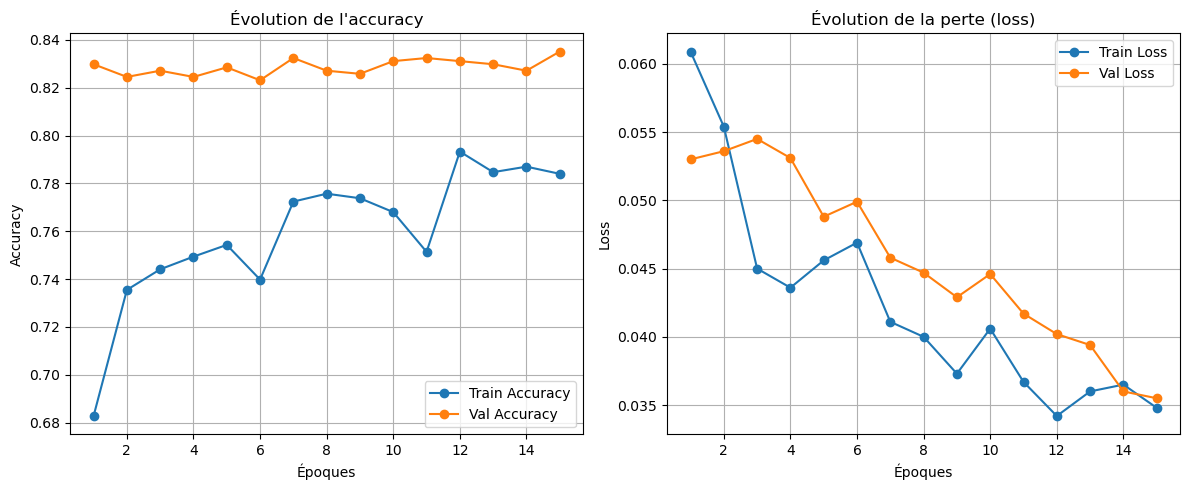

In [ ]:

epochs = range(1, 16)
train_acc = [0.6828, 0.7355, 0.7441, 0.7494, 0.7543, 0.7398, 0.7724, 0.7757, 0.7738,
             0.7680, 0.7514, 0.7933, 0.7847, 0.7870, 0.7840]
val_acc = [0.8298, 0.8245, 0.8271, 0.8245, 0.8285, 0.8231, 0.8324, 0.8271, 0.8258,
           0.8311, 0.8324, 0.8311, 0.8298, 0.8271, 0.8351]
train_loss = [0.0609, 0.0554, 0.0450, 0.0436, 0.0456, 0.0469, 0.0411, 0.0400, 0.0373, 
              0.0406, 0.0367, 0.0342, 0.0360, 0.0365, 0.0348]
val_loss = [0.0530, 0.0536, 0.0545, 0.0531, 0.0488, 0.0499, 0.0458, 0.0447, 0.0429,
            0.0446, 0.0417, 0.0402, 0.0394, 0.0360, 0.0355]

# Courb d'apprentissage
plt.figure(figsize=(12, 5))

# Courb d'accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Val Accuracy', marker='o')
plt.title("Évolution de l'accuracy")
plt.xlabel("Époques")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Courb de perte
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Val Loss', marker='o')
plt.title("Évolution de la perte (loss)")
plt.xlabel("Époques")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [14]:
test_dir = "C:/Users/josep/OneDrive/Documenten/project419/FracAtlas/Test"
test_gen = ImageDataGenerator(rescale=1./255)

test_generator = test_gen.flow_from_directory(
    directory=test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 1572 images belonging to 2 classes.


In [15]:
model = load_model("best_model.h5", custom_objects={'focal_loss_fixed': focal_loss()})
pred_probs = model.predict(test_generator)
true_labels = test_generator.classes

50/50 ━━━━━━━━━━━━━━━━━━━━ 219s 4s/step



--- Évaluation pour seuil = 0.15 ---
Accuracy : 63.49%
Classification Report :
              precision    recall  f1-score   support

           0       0.93      0.60      0.73      1297
           1       0.29      0.78      0.43       275

    accuracy                           0.63      1572
   macro avg       0.61      0.69      0.58      1572
weighted avg       0.82      0.63      0.68      1572

Matrice de confusion :
[[783 514]
 [ 60 215]]


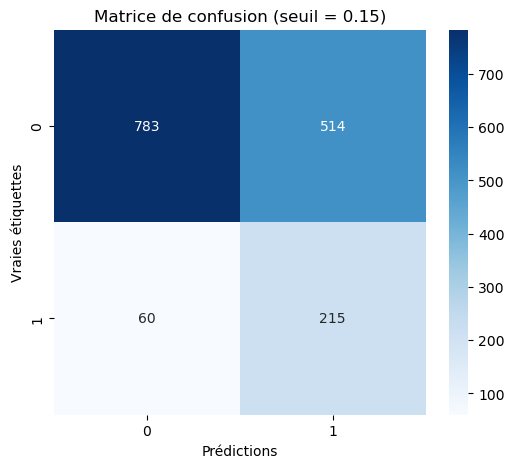


--- Évaluation pour seuil = 0.25 ---
Accuracy : 82.12%
Classification Report :
              precision    recall  f1-score   support

           0       0.87      0.92      0.89      1297
           1       0.49      0.37      0.42       275

    accuracy                           0.82      1572
   macro avg       0.68      0.65      0.66      1572
weighted avg       0.81      0.82      0.81      1572

Matrice de confusion :
[[1188  109]
 [ 172  103]]


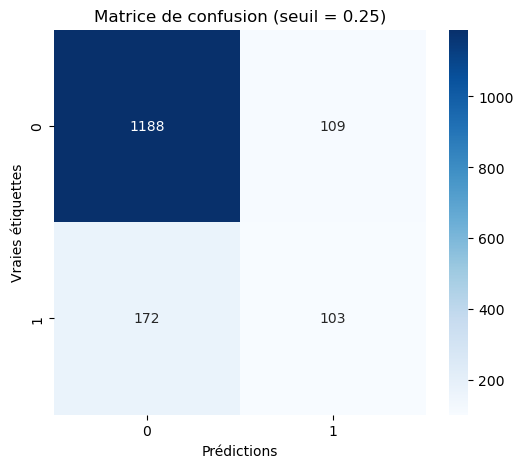


--- Évaluation pour seuil = 0.35 ---
Accuracy : 84.86%
Classification Report :
              precision    recall  f1-score   support

           0       0.85      0.99      0.91      1297
           1       0.76      0.20      0.31       275

    accuracy                           0.85      1572
   macro avg       0.81      0.59      0.61      1572
weighted avg       0.84      0.85      0.81      1572

Matrice de confusion :
[[1280   17]
 [ 221   54]]


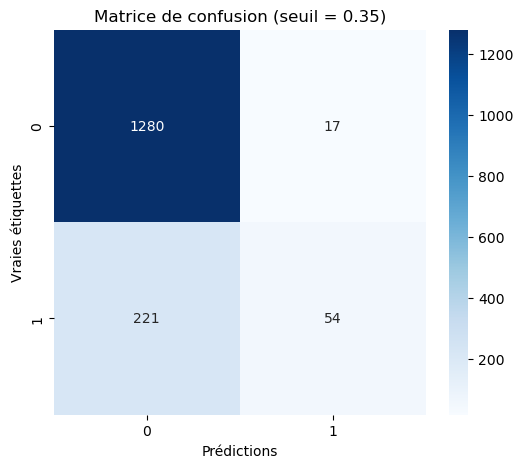


--- Évaluation pour seuil = 0.5 ---
Accuracy : 83.33%
Classification Report :
              precision    recall  f1-score   support

           0       0.83      1.00      0.91      1297
           1       1.00      0.05      0.09       275

    accuracy                           0.83      1572
   macro avg       0.92      0.52      0.50      1572
weighted avg       0.86      0.83      0.77      1572

Matrice de confusion :
[[1297    0]
 [ 262   13]]


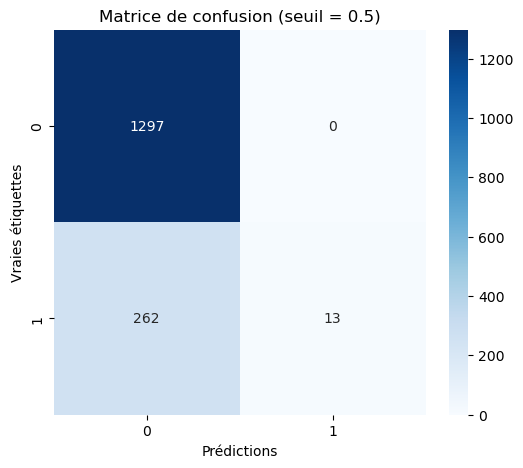

In [16]:
for threshold in [0.15, 0.25, 0.35, 0.5]:
    print(f"\n--- Évaluation pour seuil = {threshold} ---")
    pred_classes = (pred_probs > threshold).astype("int32").reshape(-1)
    acc = accuracy_score(true_labels, pred_classes)
    print(f"Accuracy : {acc * 100:.2f}%")
    print("Classification Report :")
    print(classification_report(true_labels, pred_classes))
    print("Matrice de confusion :")
    cm = confusion_matrix(true_labels, pred_classes)
    print(cm)
    
    # Visualisation de la matrice de confusion
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
    plt.xlabel('Prédictions')
    plt.ylabel('Vraies étiquettes')
    plt.title(f'Matrice de confusion (seuil = {threshold})')
    plt.show()


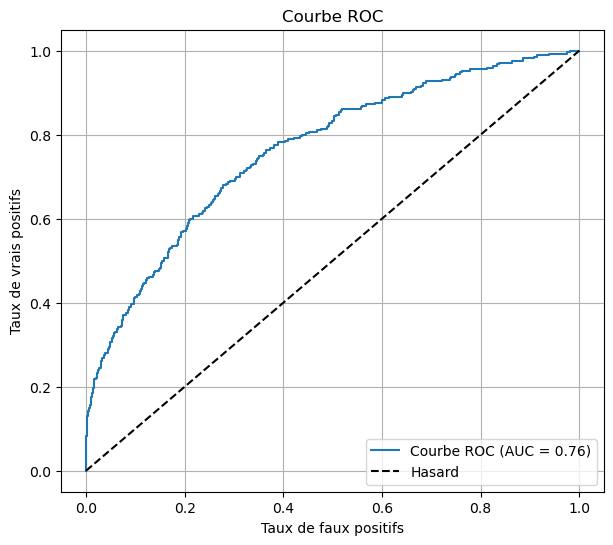

In [17]:
fpr, tpr, _ = roc_curve(true_labels, pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f"Courbe ROC (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Hasard")
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.title("Courbe ROC")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [18]:
from sklearn.metrics import precision_recall_curve, f1_score

In [19]:
# Calcul de la courbe Précision-Rappel
precision, recall, thresholds = precision_recall_curve(true_labels, pred_probs)

# Calcul du F1-score pour chaque seuil
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)

# Trouver le seuil optimal
best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index]
best_f1 = f1_scores[best_index]

print(f"\n Seuil optimal basé sur le F1-score : {best_threshold:.2f} (F1 = {best_f1:.2f})")


 Seuil optimal basé sur le F1-score : 0.20 (F1 = 0.46)


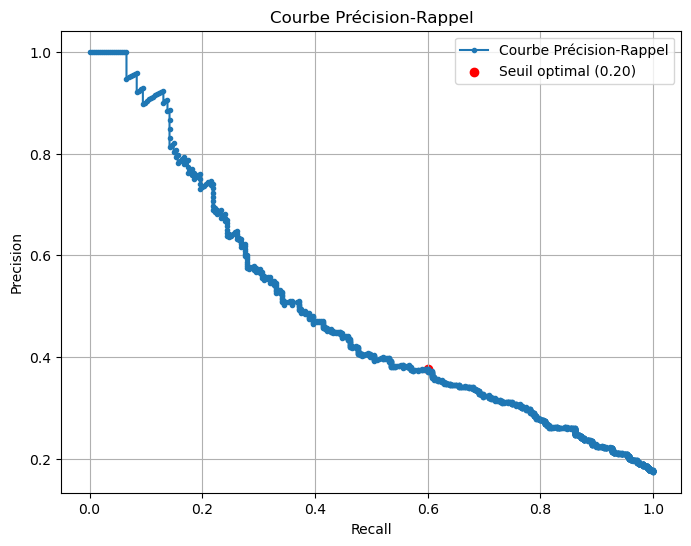

In [20]:
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Courbe Précision-Rappel')
plt.scatter(recall[best_index], precision[best_index], color='red', label=f'Seuil optimal ({best_threshold:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Courbe Précision-Rappel')
plt.legend()
plt.grid(True)
plt.show()

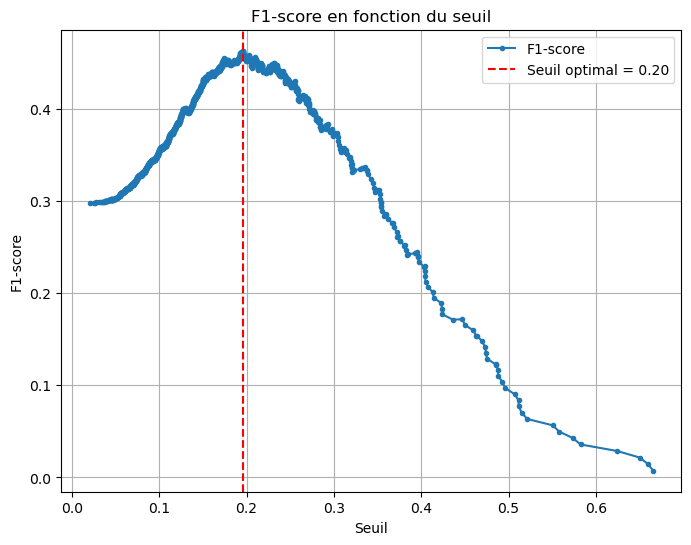

In [21]:
plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores[:-1], marker='.', label='F1-score')
plt.axvline(x=best_threshold, color='red', linestyle='--', label=f'Seuil optimal = {best_threshold:.2f}')
plt.xlabel('Seuil')
plt.ylabel('F1-score')
plt.title('F1-score en fonction du seuil')
plt.legend()
plt.grid(True)
plt.show()

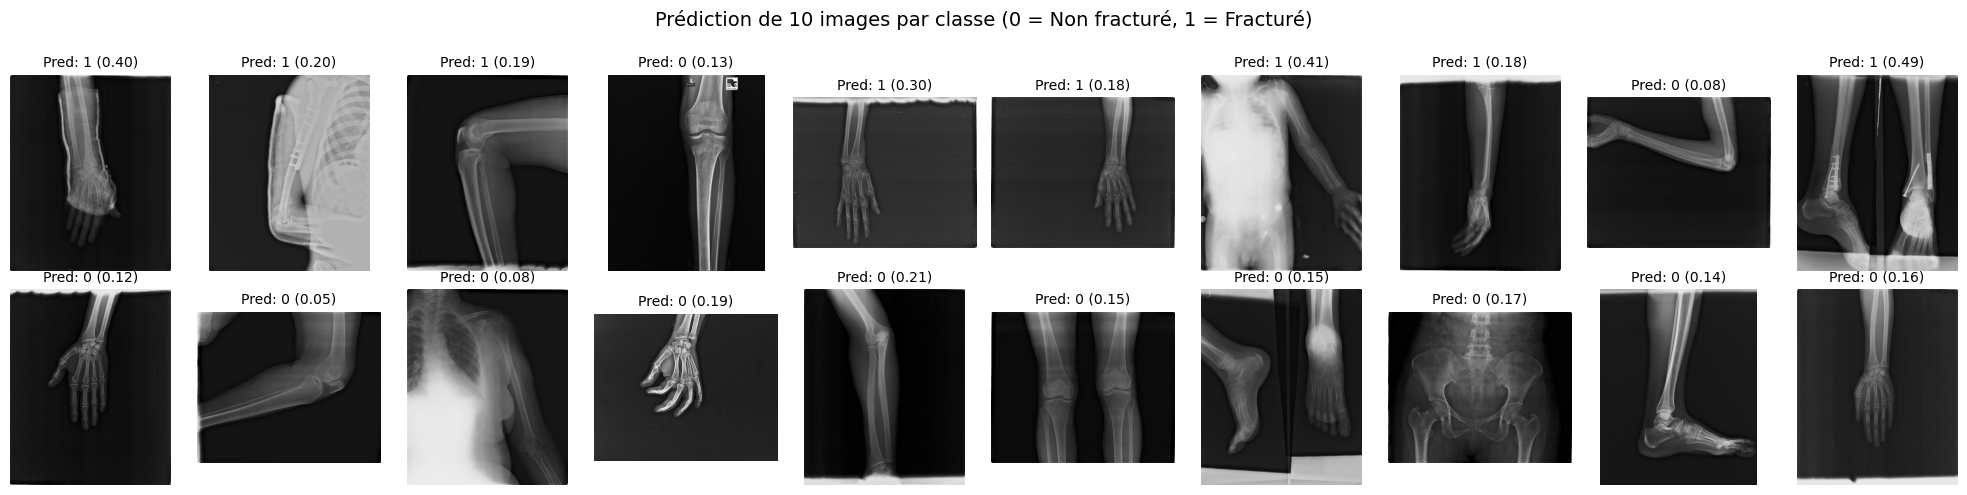


=== STATISTIQUES (seuil = 0.5) ===
Accuracy globale: 50.0%
Fractures correctement identifiées: 0/10
Non-fractures correctement identifiées: 10/10
Taux de vrais positifs (fractures): 0.0%
Taux de vrais négatifs (non-fractures): 100.0%


In [ ]:

from tensorflow.keras.preprocessing.image import load_img, img_to_array


model_path = "best_model.h5"  #  meilleur modèle sauvega.
image_size = (224, 224)
base_test_dir = "C:/Users/josep/OneDrive/Documenten/project419/FracAtlas/Test"


model = load_model(model_path, custom_objects={'focal_loss_fixed': focal_loss()})


def predict_image(path):
    """Prédit la probabilité de fracture pour une image"""
    img = load_img(path, target_size=image_size)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    pred = model.predict(img_array, verbose=0)[0][0]
    return pred


fractured_dir = os.path.join(base_test_dir, "1_Fractured")
nonfractured_dir = os.path.join(base_test_dir, "0_Non_fractured")

if not os.path.exists(fractured_dir) or not os.path.exists(nonfractured_dir):
    print("Erreur: Les dossiers de test n'existent pas aux chemins spécifiés")
else:
    
    all_fractured = [f for f in os.listdir(fractured_dir) if f.endswith('.jpg')]
    all_nonfractured = [f for f in os.listdir(nonfractured_dir) if f.endswith('.jpg')]
    
    # Sélectionne aléatoirement 10 images de chaque classe
    fractured_imgs = random.sample(all_fractured, min(10, len(all_fractured)))
    nonfractured_imgs = random.sample(all_nonfractured, min(10, len(all_nonfractured)))
    
    # predi
    fig, axs = plt.subplots(2, 10, figsize=(20, 5))
    fig.suptitle("Prédiction de 10 images par classe (0 = Non fracturé, 1 = Fracturé)", fontsize=14)
    
    #   Ai fracturées (première ligne)
    for i, img_name in enumerate(fractured_imgs):
        path = os.path.join(fractured_dir, img_name)
        pred = predict_image(path)
        pred_class = int(pred > 0.15)  # Seuil de 0.15 par défaut
        
        axs[0, i].imshow(load_img(path), cmap='gray')
        axs[0, i].set_title(f"Pred: {pred_class} ({pred:.2f})", fontsize=10)
        axs[0, i].axis('off')
    
    # Ai non fracturées (deuxième ligne)
    for i, img_name in enumerate(nonfractured_imgs):
        path = os.path.join(nonfractured_dir, img_name)
        pred = predict_image(path)
        pred_class = int(pred > 0.5)  # Seuil de 0.5 par défaut
        
        axs[1, i].imshow(load_img(path), cmap='gray')
        axs[1, i].set_title(f"Pred: {pred_class} ({pred:.2f})", fontsize=10)
        axs[1, i].axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

# seuil personnalise
def display_predictions_with_threshold(threshold=0.2):
    """Affiche les prédictions avec un seuil personnalisé"""
    fig, axs = plt.subplots(2, 10, figsize=(20, 5))
    fig.suptitle(f"Prédictions avec seuil {threshold} (0 = Non fracturé, 1 = Fracturé)", fontsize=14)
    
    # Ai fracturées (première ligne)
    for i, img_name in enumerate(fractured_imgs):
        path = os.path.join(fractured_dir, img_name)
        pred = predict_image(path)
        pred_class = int(pred > threshold)
        
        axs[0, i].imshow(load_img(path), cmap='gray')
        axs[0, i].set_title(f"Pred: {pred_class} ({pred:.2f})", fontsize=10)
        axs[0, i].axis('off')
    
    # Ai non fracturées (deuxième ligne)
    for i, img_name in enumerate(nonfractured_imgs):
        path = os.path.join(nonfractured_dir, img_name)
        pred = predict_image(path)
        pred_class = int(pred > threshold)
        
        axs[1, i].imshow(load_img(path), cmap='gray')
        axs[1, i].set_title(f"Pred: {pred_class} ({pred:.2f})", fontsize=10)
        axs[1, i].axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

# A avec des seul person
# display_predictions_with_threshold(0.15)
# -----                             (0.3)
# meme chose                        (0.5)

#  statistiq rapides
def display_prediction_stats(threshold=0.2):
    """Affiche des statistiques rapides sur les prédictions"""
    correct_fractured = 0
    correct_nonfractured = 0
    
    #   evaluation les images fracturées
    for img_name in fractured_imgs:
        path = os.path.join(fractured_dir, img_name)
        pred = predict_image(path)
        if pred > threshold:  # Prédit comme fracture
            correct_fractured += 1
    
    # Évaluatio les images non fracturées
    for img_name in nonfractured_imgs:
        path = os.path.join(nonfractured_dir, img_name)
        pred = predict_image(path)
        if pred <= threshold:  # Prédit comme non-fracture
            correct_nonfractured += 1
    
    total_correct = correct_fractured + correct_nonfractured
    accuracy = (total_correct / 20) * 100
    
    print(f"\n STATISTIQUES (seuil = {threshold})")
    print(f"Accuracy globale: {accuracy:.1f}%")
    print(f"Fractures correctement identifiées: {correct_fractured}/10")
    print(f"Non-fractures correctement identifiées: {correct_nonfractured}/10")
    print(f"Taux de vrais positifs (fractures): {correct_fractured/10*100:.1f}%")
    print(f"Taux de vrais négatifs (non-fractures): {correct_nonfractured/10*100:.1f}%")


display_prediction_stats(0.5)